# <center> Machine learning</center>
## <center> Introduction et quelques examples pour le sport </center>
### <center> Estimation de position </center>


### <center> École d'été <span style="font-variant:small-caps;">Sciences</span><sup>2024</sup> Édition 2023</center>


<center> Rémi Carmigniani</center>

In [9]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import pickle
import numpy as np
from glob import glob
from pathlib import Path
import shutil

import keras

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,GlobalAveragePooling2D,SeparableConv2D,Flatten,MaxPool2D
from keras.layers import UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add,Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard, TerminateOnNaN
import keras.backend as K
#
import scipy
import math
import sys
from config_reader import config_reader
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import util
tf.config.list_physical_devices('GPU')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Demo Open Pose

In [ ]:
test_image = 'examples/grousset-maxime_sk48836.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])
plt.axis(False)
plt.show()

In [ ]:
param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

In [ ]:
model = load_model('models/model_openPose_full.h5')

In [ ]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1],19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    ax2 = axarr2[m].imshow(heatmap[:,:,3], alpha=.5) # right elbow
    axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
    
    axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    ax3x = axarr3.flat[m].imshow(paf[:,:,16], alpha=.5) # right elbow
    axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
    ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,17], alpha=.5) # right wrist
    axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)

f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy
plt.show()

In [ ]:
f, axarr = plt.subplots(1, 1)
plt.imshow(oriImg[:,:,[2,1,0]])
ax =plt.imshow(heatmap_avg[:,:,4],alpha=0.4)
plt.axis(False)

#f.subplots_adjust(right=4)
cbar_ax = f.add_axes([0.1, 0.1, 0.01, 0.7])
_ = f2.colorbar(ax, cax=cbar_ax)
#plt.axis(False)
plt.tight_layout()
plt.savefig('../../Presentation/img/PoseEstimation_example_1.png',bbox_inches='tight')
plt.show()


In [ ]:
for i in range(14):
    plt.imshow(heatmap_avg[:,:,i])
    plt.axis(False)
    plt.tight_layout()
    plt.savefig('examples/mask%02d.png'%i,bbox_inches='tight')
    plt.close()

In [ ]:
oriImg.shape

# UNet Simple

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [28]:
def get_unet(input_img, n_filters = 16,dropout = 0.1, batchnorm = True,num_classes=10):
    """Function to define the UNET Model"""
    input_unet = Lambda(lambda x: x / 256 - 0.5)(input_img)  # [-0.5, 0.5]
    # Contracting Path
    c1 = conv2d_block(input_unet, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
   

    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs_masks = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
        
    model = Model(inputs=[input_img], outputs=[outputs_masks])
    
    return model

In [31]:
input_img = Input((160,160,3), name='img')
model = get_unet(input_img, n_filters=16,num_classes=8, dropout=0.05, batchnorm=True)

In [32]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 160, 160, 3)  0           img[0][0]                        
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 160, 160, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_122 (BatchN (None, 160, 160, 16) 64          conv2d_128[0][0]                 
____________________________________________________________________________________________

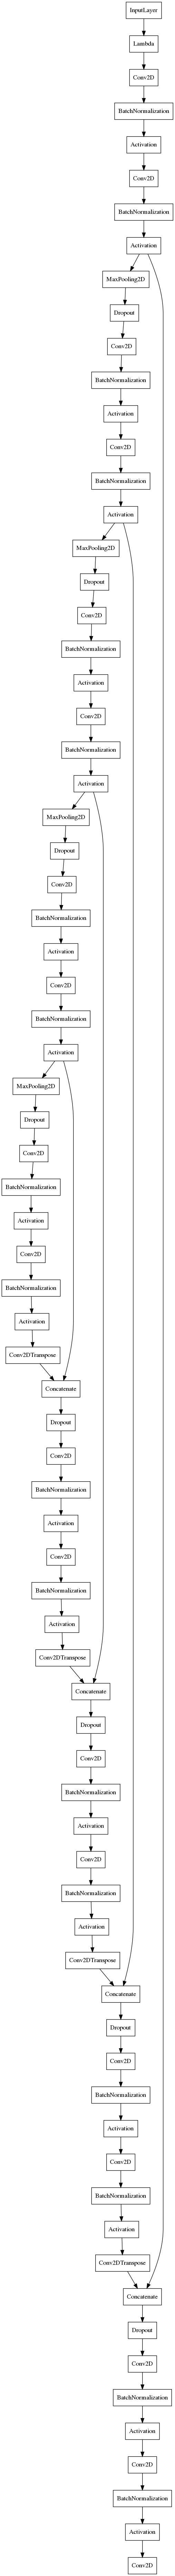

In [33]:
dot_img_file = '../../Presentation/img/modelUnet.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False,expand_nested=True,
                          show_layer_names=False)